In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import numpy as np
import shutil
import os

In [28]:
ORIG_INPUT_DATASET = "House_Room_Dataset/Bedroom"
#Dataset link = https://www.kaggle.com/datasets/robinreni/house-rooms-image-dataset
##kaggle datasets download -d robinreni/house-rooms-image-dataset — unzip

TRAIN = "training"
TEST = "evaluation"
VAL = "validation"

BASE_PATH = "dataset"
BATCH_SIZE = 32
CLASSES = ["Modern", "Old"] # "Neutral", 

In [10]:
def plot_hist(hist, metric):
    if metric == 'auc_3':
        plt.plot(hist.history["auc_3"])
        plt.plot(hist.history["val_auc_3"])
    else:
        plt.plot(hist.history["loss"])
        plt.plot(hist.history["val_loss"])
    plt.style.use("ggplot")
    plt.title("model {}".format(metric))
    plt.ylabel("{}".format(metric))
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [13]:
with open("labels.txt", 'r') as f:
    manual_labels = f.read()
    
labels = [i for i in manual_labels]
len(labels)

451

In [15]:
from collections import Counter
print(Counter(labels).keys()) 
print(Counter(labels).values())

dict_keys(['O', 'M'])
dict_values([271, 180])


In [16]:
files = os.listdir(ORIG_INPUT_DATASET)
files.sort(key=lambda f: int(f.split('_')[1].split('.')[0]))

In [17]:
files[:5]

['bed_1.jpg', 'bed_2.jpg', 'bed_3.jpg', 'bed_4.jpg', 'bed_8.jpg']

In [ ]:
#We will allocate ~ 75%, 15%, and 10% of the data for training, validation, and testing, respectively.

In [18]:
# splitting files into train and test sets
trainX, testX, trainY, testY =  train_test_split(files[:len(labels)], 
                 labels, 
                 stratify=labels, 
                 train_size=0.90)

In [19]:
# further splitting of train set into train and val sets
trainX, valX, trainY, valY = train_test_split(trainX, trainY, stratify=trainY, train_size=0.85)

In [20]:
# Checking the size of train, test, eval
len(trainX), len(trainY), len(valX), len(valY),  len(testX), len(testY)

(344, 344, 61, 61, 46, 46)

In [29]:
import os
import shutil
from tqdm import tqdm

# Define configuration settings directly in the script
BASE_PATH = "House_Room_Dataset/Bedroom"

# Example data splits and labels
splits = [(trainX, trainY), (testX, testY), (valX, valY)]
dirnames = ['training', 'evaluation', 'validation']

for i, (data, label) in enumerate(splits):
    outside_dir = dirnames[i]

    for j in tqdm(range(0, len(label)), desc=f"Iterating over images in {outside_dir} folder"):
        dir = label[j]

        # Construct the path to the sub-directory
        dirPath = os.path.join(BASE_PATH, outside_dir, dir)

        # If the output directory does not exist, create it
        if not os.path.exists(dirPath):
            os.makedirs(dirPath)

        # Copy the image to this new directory
        src_img = os.path.join(ORIG_INPUT_DATASET, data[j])
        shutil.copy(src_img, dirPath)


Iterating over images in validation folder: 100%|██████████| 61/61 [00:00<00:00, 63.89it/s]


In [30]:
trainPath = os.path.join(BASE_PATH, TRAIN)
valPath = os.path.join(BASE_PATH, VAL)
testPath = os.path.join(BASE_PATH, TEST)
totalTrain = len(list(paths.list_images(trainPath)))
totalVal = len(list(paths.list_images(valPath)))
totalTest = len(list(paths.list_images(testPath)))
print(totalTrain, totalTest, totalVal)

344 46 61


In [31]:
trainAug = ImageDataGenerator(
rotation_range=90,
zoom_range=[0.5, 1.0],
width_shift_range=0.3,
height_shift_range=0.25,
shear_range=0.15,
horizontal_flip=True,
fill_mode="nearest",
brightness_range=[0.2, 1.0]
)

In [32]:
valAug = ImageDataGenerator()

In [33]:
testAug = ImageDataGenerator()

In [44]:
# Create training batches whilst creating augmented images on the fly
trainGen = trainAug.flow_from_directory(
directory=trainPath,
target_size=(224,224),
save_to_dir='dataset/augmented/train',
save_prefix='train',
shuffle=True
)


Found 344 images belonging to 2 classes.


In [45]:
# Create val batches 
valGen = valAug.flow_from_directory(
directory=valPath,
target_size=(224,224),
shuffle=True)

Found 61 images belonging to 2 classes.


In [35]:
# Create test batches
testGen = testAug.flow_from_directory(
directory=testPath,
target_size=(224,224),
shuffle=False
)

Found 46 images belonging to 2 classes.


In [36]:
baseModel = EfficientNetB0(
            weights="imagenet",
            include_top=False, # make sure top layer is not included
            input_tensor=Input(shape=(224, 224, 3)),
            pooling="avg"
           )

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 31s 2us/step


In [37]:
# freeze the weights
for layer in baseModel.layers:
      layer.trainable = False

In [38]:
# training a new classifier on top (Functional Keras Model)
x = baseModel.output
Layer_1 = BatchNormalization()(x)
Layer_2 = Dropout(0.5)(Layer_1)
output_layer = Dense(len(CLASSES), activation="softmax")(Layer_2)
model = Model(inputs = baseModel.input, outputs = output_layer)

In [39]:
# Another way to create the classifier on top of basemodel
model = tf.keras.Sequential()
model.add(baseModel)
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(CLASSES), activation="softmax"))

In [40]:
# compile
opt = Adam(learning_rate=1e-3)
model.compile(optimizer=opt, 
              loss='binary_crossentropy', 
              metrics=[tf.keras.metrics.AUC()]
              )

In [42]:
# implementing early stopping
es = EarlyStopping(
     monitor='val_loss',  #metric to monitor
     mode='min',  # whether to min or max the metric monitored
     patience=10, # epochs to wait before declaring stopped training
     verbose=1  # output epoch when training was stopped
     )
# implementing model checkpoint
mc = ModelCheckpoint(
      'feature_extraction.keras',
       monitor='val_loss',
       mode='min',
       verbose=1, # display epoch+accuracy everytime model is saved
       save_best_only=True
      )

In [47]:
os.makedirs('dataset/augmented/train', exist_ok=True)

In [48]:
# Training the model
hist = model.fit(
       x=trainGen,
       epochs=25,
       verbose=2,
       validation_data=valGen,
       steps_per_epoch=totalTrain // BATCH_SIZE,
       callbacks=[es, mc]
      )

Epoch 1/25


c:\Anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.67781, saving model to feature_extraction.keras
10/10 - 66s - 7s/step - auc: 0.6137 - loss: 0.9065 - val_auc: 0.6502 - val_loss: 0.6778
Epoch 2/25


c:\Anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.67781 to 0.67619, saving model to feature_extraction.keras
10/10 - 4s - 401ms/step - auc: 0.6221 - loss: 0.8692 - val_auc: 0.6595 - val_loss: 0.6762
Epoch 3/25

Epoch 3: val_loss improved from 0.67619 to 0.66095, saving model to feature_extraction.keras
10/10 - 25s - 2s/step - auc: 0.6009 - loss: 0.8677 - val_auc: 0.6809 - val_loss: 0.6610
Epoch 4/25

Epoch 4: val_loss improved from 0.66095 to 0.65981, saving model to feature_extraction.keras
10/10 - 3s - 344ms/step - auc: 0.7188 - loss: 0.7820 - val_auc: 0.6818 - val_loss: 0.6598
Epoch 5/25

Epoch 5: val_loss improved from 0.65981 to 0.65033, saving model to feature_extraction.keras
10/10 - 25s - 2s/step - auc: 0.6846 - loss: 0.8008 - val_auc: 0.6915 - val_loss: 0.6503
Epoch 6/25

Epoch 6: val_loss improved from 0.65033 to 0.64943, saving model to feature_extraction.keras
10/10 - 4s - 361ms/step - auc: 0.7852 - loss: 0.6590 - val_auc: 0.6936 - val_loss: 0.6494
Epoch 7/25

Epoch 7: val_loss improved f

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step
No. of test images 46
{'M': 0, 'O': 1}


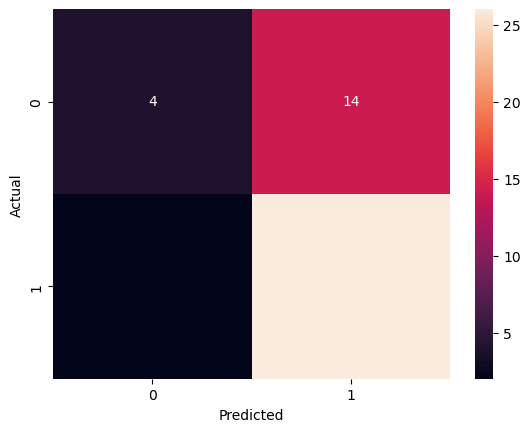

In [49]:
testGen.reset()
predIdxs = model.predict(
             x=testGen,
             steps=(totalTest // BATCH_SIZE) + 1
            )
predIdxs = np.argmax(predIdxs, axis = 1)
print("No. of test images", len(predIdxs))
print(testGen.class_indices)
cm = confusion_matrix(testGen.classes, predIdxs)
heatmap = sns.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [52]:
def fine_tune_model(model):
     # unfreeze last conv block i.e. block7a 
     for layer in model.layers[-20:]:
          if not isinstance(layer, BatchNormalization):
               layer.trainable = True
     # check which of these are trainable and which aren't
     for layer in model.layers:
          print("{}: {}".format(layer, layer.trainable))
     # compile (with an even smaller learning rate)
     opt = Adam(learning_rate=1e-5)
     model.compile(
             optimizer=opt,
             loss='binary_crossentropy',
             metrics=[tf.keras.metrics.AUC()]
             )
     return model
model_fine_tuned = fine_tune_model(model)

<Functional name=efficientnetb0, built=True>: True
<BatchNormalization name=batch_normalization_1, built=True>: True
<Dropout name=dropout_1, built=True>: True
<Dense name=dense_1, built=True>: True


In [53]:
trainGen.reset()
valGen.reset()
testGen.reset()

In [55]:
# implementing early stopping
es_tune = EarlyStopping(
     monitor='val_loss', 
     mode='min',  
     patience=20, 
     verbose=1  
     )
# implementing model checkpoint
mc_tune = ModelCheckpoint(
      'fine_tuned_house.keras',
       monitor='val_loss',
       mode='min',
       verbose=1, 
       save_best_only=True
      )
hist = model_fine_tuned.fit(
      x=trainGen,
      steps_per_epoch=totalTrain // BATCH_SIZE,
      validation_data=valGen,
      epochs=50,
      verbose=2,
      callbacks=[es_tune, mc_tune]
     )

Epoch 1/50

Epoch 1: val_loss improved from inf to 0.61314, saving model to fine_tuned_house.keras
10/10 - 60s - 6s/step - auc_1: 0.8042 - loss: 0.6180 - val_auc_1: 0.7143 - val_loss: 0.6131
Epoch 2/50


c:\Anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.61314 to 0.61300, saving model to fine_tuned_house.keras
10/10 - 4s - 353ms/step - auc_1: 0.7256 - loss: 0.7110 - val_auc_1: 0.7143 - val_loss: 0.6130
Epoch 3/50

Epoch 3: val_loss improved from 0.61300 to 0.61204, saving model to fine_tuned_house.keras
10/10 - 24s - 2s/step - auc_1: 0.7963 - loss: 0.6151 - val_auc_1: 0.7157 - val_loss: 0.6120
Epoch 4/50

Epoch 4: val_loss improved from 0.61204 to 0.61194, saving model to fine_tuned_house.keras
10/10 - 4s - 373ms/step - auc_1: 0.8887 - loss: 0.4533 - val_auc_1: 0.7170 - val_loss: 0.6119
Epoch 5/50

Epoch 5: val_loss improved from 0.61194 to 0.61102, saving model to fine_tuned_house.keras
10/10 - 23s - 2s/step - auc_1: 0.8059 - loss: 0.6215 - val_auc_1: 0.7173 - val_loss: 0.6110
Epoch 6/50

Epoch 6: val_loss improved from 0.61102 to 0.61093, saving model to fine_tuned_house.keras
10/10 - 3s - 319ms/step - auc_1: 0.8984 - loss: 0.4500 - val_auc_1: 0.7170 - val_loss: 0.6109
Epoch 7/50

Epoch 7: val_loss 

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step
No. of test images 61
{'M': 0, 'O': 1}


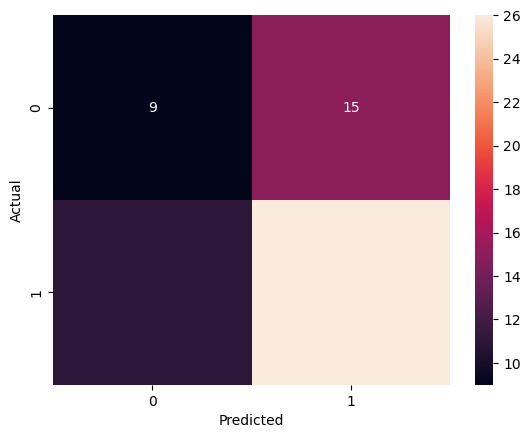

In [56]:
valGen.reset()
velIdxs = model.predict(
             x=valGen,
             steps=(totalTest // BATCH_SIZE) + 1
            )
velIdxs = np.argmax(velIdxs, axis = 1)
print("No. of test images", len(velIdxs))
print(valGen.class_indices)
cm = confusion_matrix(valGen.classes, velIdxs)
heatmap = sns.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()